In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import numpy as np
from h5py import File
import matplotlib.pyplot as plt
from tqdm import tqdm

from torch.utils.data import DataLoader, Subset
from vis_utils import plot_time_series
import numpy as np

In [2]:
# define the transform function
trans = transforms.Compose([
    transforms.ToTensor(),
])

In [3]:
class H5Dataset(torch.utils.data.Dataset):
    def __init__(self, path: str,
                 response_type: str,
                 transform: transforms.Compose = trans,
                 train: bool= True):
        self.file_path = path
        # The available types are firing_rate_10ms, binned
        self.response_type = response_type
        self.X = None
        self.y = None
        self.transform = transform
        # Choose either train or test subsets
        self.data_type = "train" if train else "test"
        with File(self.file_path, 'r') as file:
            self.dataset_len = len(file[self.data_type]["stimulus"])

    def __getitem__(self, idx: int):
        if self.X is None or self.y is None:
            h5file = File(self.file_path, 'r')
            # Read as numpy array
            # TODO: see if there is a better way
            self.X = np.asarray(h5file[self.data_type]["stimulus"])
            self.y = np.asarray(h5file[self.data_type]["response"][self.response_type])
            # Swap axes of y since it is channels last
            self.y = np.transpose(self.y, axes=None)
            self.y = self.y.astype("float32")

        # transform the data
        x = self.transform(self.X[idx])
        y = torch.tensor(self.y[idx], dtype=torch.float32)
        # add small epsilon to zero-values inside y
        # y[y == 0] = 1e-6
        return x, y

    def __len__(self):
        return self.dataset_len

In [4]:
# adjust a path to the sample h5 file
dataset_path = "../data/neural_code_data/neural_code_data/ganglion_cell_data/15-10-07/naturalscene.h5"

train_dataset = H5Dataset(dataset_path, response_type="firing_rate_10ms", train=True)
# val_dataset = H5Dataset(dataset_path, response_type="firing_rate_10ms", train=True)
test_dataset = H5Dataset(dataset_path, response_type="firing_rate_10ms", train=False)

In [5]:
# # Determine the split point
# dataset_len = len(train_dataset)
# train_split = int(0.8 * dataset_len)  # 80% for training
# val_split = dataset_len - train_split  # 20% for validation

# train_indices = list(range(train_split))
# val_indices = list(range(train_split, dataset_len))

# train_dataset = Subset(train_dataset, train_indices)
# val_dataset = Subset(train_dataset, val_indices)
print("Number of training images", len(train_dataset))
# print("Number of validation images", len(val_dataset))
print("Number of testing images", len(test_dataset))

Number of training images 359802
Number of testing images 5996


In [6]:
# create data loaders
BATCH_SIZE = 2500
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
# val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Model definition #

Very simple CNN model at the beginning. In the first trial approach we will train the model that tries to predict original response values in the range [0, inf).


In [7]:
class RetinaCNN(nn.Module):
    def __init__(self, 
                 out_channels: int = 8,
                 n_units: int = 9):
        super(RetinaCNN, self).__init__()
        self.out_channels = out_channels
        self.n_units = n_units
        # some hyperparameters from the original repo
        self.bn_moment = 0.01
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels, eps=1e-3,
                                         momentum=self.bn_moment)
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels= 2 * out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(2 * out_channels, eps=1e-3,
                                         momentum=self.bn_moment)
        self.conv3 = nn.Conv2d(in_channels=2 * out_channels, out_channels= 4 * out_channels, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(4 * out_channels, eps=1e-3,
                                         momentum=self.bn_moment)
        # Fully connected layer
        self.fc = nn.Linear(50 * 50 * 4 * out_channels, self.n_units, bias=True)
        self.bn4 = nn.BatchNorm1d(self.n_units, eps=1e-3,
                                         momentum=self.bn_moment)
        self.softplus = nn.Softplus()

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        # Flatten the output from the convolutional layers
        x = x.view(x.size(0), -1)  # Flatten all dimensions except the batch
        # Forward pass through the fully connected layer to predict ganglion cell responses
        x = self.fc(x)
        x = self.bn4(x)
        x = self.softplus(x)
        return x

model = RetinaCNN()

In [8]:
class WeightedMSELoss(nn.Module):
    def __init__(self, weight=1.0):
        super(WeightedMSELoss, self).__init__()
        self.weight = weight

    def forward(self, inputs, targets):
        weights = torch.where(targets > 1, self.weight, 1.0)
        return torch.mean(weights * (inputs - targets) ** 2)

In [9]:
# define training parameters
LEARNING_RATE = 0.005
EPOCHS = 40
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = WeightedMSELoss(weight=10)




In [10]:
min_valid_loss = np.inf
history = {'train_losses': [], 'valid_losses': []}

model.cuda()
# model.train()

for epoch in range(EPOCHS):
    model.train()
    train_batch_losses = []
    for data, labels in tqdm(train_loader, desc='Training Batches', leave=False):
        model.zero_grad()
        optimizer.zero_grad()
        images = data.cuda()
        targets = labels.cuda()
        outputs = model(images)
        
        loss = loss_fn(outputs, targets)

        loss.backward()
        optimizer.step()
        train_batch_losses.append(loss.item())
    train_loss = np.sum(train_batch_losses) / len(train_batch_losses)
    history['train_losses'].append(train_loss)

    # model.eval()
    # fin_targets=[]
    # fin_outputs=[]
    # valid_batch_losses=[]
    # with torch.no_grad():
    #     for data, labels in val_loader:
    #         images = data.cuda()
    #         targets = labels.cuda()
    #         outputs = model(images)

    #         loss = loss_fn(outputs, targets)
    #         valid_batch_losses.append(loss.item())
    #     valid_loss = np.sum(valid_batch_losses) / len(valid_batch_losses)
    #     history['valid_losses'].append(valid_loss)
    
    # if min_valid_loss > valid_loss:
    #     torch.save(model.state_dict(), '../models/best_model_3conv_1unit_overfit-07-notebook.pth')
    #     min_valid_loss = valid_loss
    
    print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss} \t\t Validation Loss: {train_loss}')
    # print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss}')


    torch.save(model.state_dict(), '../models/final_model_3conv_1unit_overfit-07-notebook.pth')

Training Batches:   0%|          | 0/144 [00:00<?, ?it/s]/root/miniconda3/envs/neural_deep/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608935911/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1 		 Training Loss: 1034.3428910573323 		 Validation Loss: 1034.3428910573323


Epoch 2 		 Training Loss: 997.9810314178467 		 Validation Loss: 997.9810314178467


Epoch 3 		 Training Loss: 959.3417500389946 		 Validation Loss: 959.3417500389946


Epoch 4 		 Training Loss: 918.9385386572944 		 Validation Loss: 918.9385386572944


Epoch 5 		 Training Loss: 877.0918515523275 		 Validation Loss: 877.0918515523275


Epoch 6 		 Training Loss: 834.4782610999214 		 Validation Loss: 834.4782610999214


Epoch 7 		 Training Loss: 793.839799033271 		 Validation Loss: 793.839799033271


Epoch 8 		 Training Loss: 760.1835526360405 		 Validation Loss: 760.1835526360405


Epoch 9 		 Training Loss: 723.7153000301785 		 Validation Loss: 723.7153000301785


Epoch 10 		 Training Loss: 691.9981530507406 		 Validation Loss: 691.9981530507406


Epoch 11 		 Training Loss: 661.8314715491401 		 Validation Loss: 661.8314715491401


Epoch 12 		 Training Loss: 636.1466092003716 		 Validation Loss: 636.1466092003716


Epoch 13 		 Training Loss: 611.1657757229275 		 Validation Loss: 611.1657757229275


Epoch 14 		 Training Loss: 592.2400688595242 		 Validation Loss: 592.2400688595242


Epoch 15 		 Training Loss: 576.5225524902344 		 Validation Loss: 576.5225524902344


Epoch 16 		 Training Loss: 560.887113571167 		 Validation Loss: 560.887113571167


Epoch 17 		 Training Loss: 547.9138611687554 		 Validation Loss: 547.9138611687554


Epoch 18 		 Training Loss: 539.3429775238037 		 Validation Loss: 539.3429775238037


Epoch 19 		 Training Loss: 525.299439324273 		 Validation Loss: 525.299439324273


Epoch 20 		 Training Loss: 515.4788572523329 		 Validation Loss: 515.4788572523329


Epoch 21 		 Training Loss: 506.98941866556805 		 Validation Loss: 506.98941866556805


Epoch 22 		 Training Loss: 501.8660617404514 		 Validation Loss: 501.8660617404514


Epoch 23 		 Training Loss: 495.7702990637885 		 Validation Loss: 495.7702990637885


Epoch 24 		 Training Loss: 489.7473500569661 		 Validation Loss: 489.7473500569661


Epoch 25 		 Training Loss: 485.95986641777887 		 Validation Loss: 485.95986641777887


Epoch 26 		 Training Loss: 482.03249104817706 		 Validation Loss: 482.03249104817706


Epoch 27 		 Training Loss: 479.4251874287923 		 Validation Loss: 479.4251874287923


Epoch 28 		 Training Loss: 478.20359293619794 		 Validation Loss: 478.20359293619794


Epoch 29 		 Training Loss: 475.52535883585614 		 Validation Loss: 475.52535883585614


Epoch 30 		 Training Loss: 472.55710940890845 		 Validation Loss: 472.55710940890845


Epoch 31 		 Training Loss: 470.59657796223956 		 Validation Loss: 470.59657796223956


Epoch 32 		 Training Loss: 469.83021036783856 		 Validation Loss: 469.83021036783856


Epoch 33 		 Training Loss: 468.15020921495227 		 Validation Loss: 468.15020921495227


Epoch 34 		 Training Loss: 466.69588057200116 		 Validation Loss: 466.69588057200116


Epoch 35 		 Training Loss: 466.1419098112318 		 Validation Loss: 466.1419098112318


Epoch 36 		 Training Loss: 464.7552218967014 		 Validation Loss: 464.7552218967014


Epoch 37 		 Training Loss: 463.8662799199422 		 Validation Loss: 463.8662799199422


Epoch 38 		 Training Loss: 462.0850418938531 		 Validation Loss: 462.0850418938531


Epoch 39 		 Training Loss: 459.73679553137885 		 Validation Loss: 459.73679553137885


Epoch 40 		 Training Loss: 457.46563084920246 		 Validation Loss: 457.46563084920246


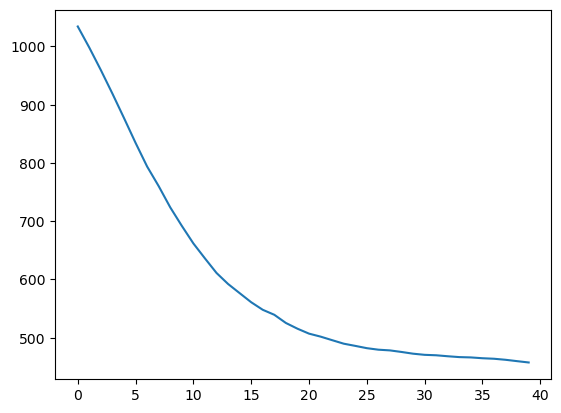

In [11]:
# plot the training and validation losses
plt.plot(history['train_losses'], label='Training Loss')
plt.plot(history['valid_losses'], label='Validation Loss')

# Inference test set

Plot the actual and predicted values and calculate the correlation

In [12]:
# function for a test loader predictions
def predict_loader(model, data_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for data, labels in tqdm(data_loader, desc='Batches'):
            images = data.cuda()
            targets = labels.cuda()
            # targets = torch.exp(targets)
            outputs = model(images)
            # outputs = torch.exp(outputs)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(outputs.cpu().detach().numpy().tolist())
    return np.array(fin_outputs), np.array(fin_targets)


In [14]:
# load the best model
model = RetinaCNN()
model.load_state_dict(torch.load('../models/final_model_3conv_1unit_overfit-07-notebook.pth'))
model.cuda()

RetinaCNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(8, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  (fc): Linear(in_features=80000, out_features=9, bias=True)
  (bn4): BatchNorm1d(9, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  (softplus): Softplus(beta=1.0, threshold=20.0)
)

In [15]:
predictions, targets = predict_loader(model, test_loader)

Batches: 100%|██████████| 3/3 [00:00<00:00,  5.56it/s]


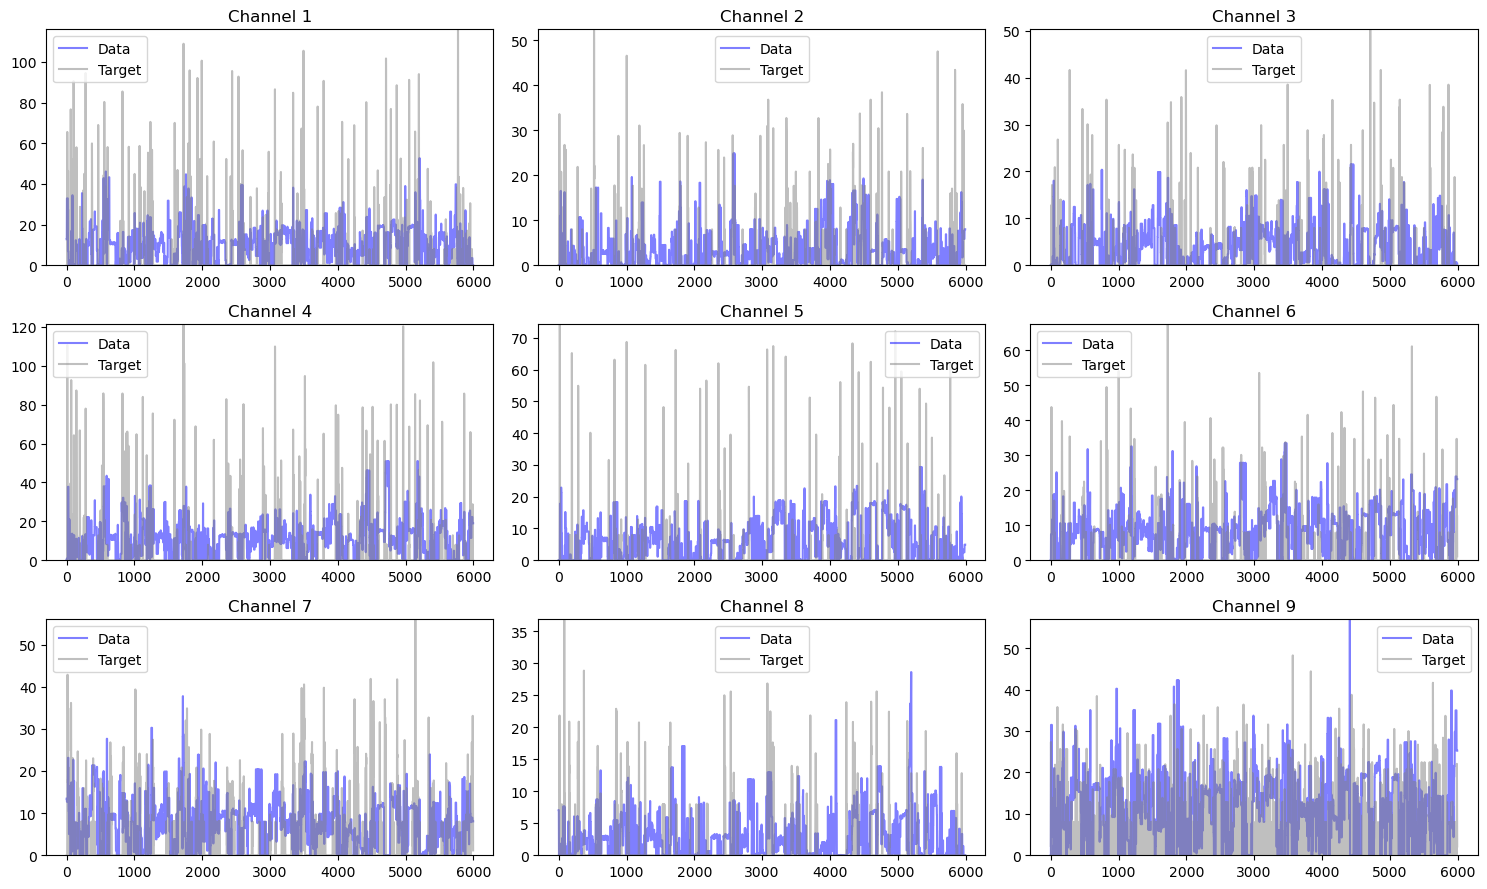

In [16]:
plot_time_series(np.transpose(predictions), np.transpose(targets))

In [ ]:
max(np.transpose(predictions)[0])

3.4512012004852295